In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

font = {
    "family": "Times New Roman",
    'size': 18
}

matplotlib.rc('font', **font)

df = pd.read_csv('../data/worker.csv')
df.head()

,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES
0,28613,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-master-0,master,8bd29cd3a6c570901c5ce23aa0a5557266068fc370e1e4...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
1,28614,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-0,worker,46547b40034dea27dff7a94dee665d3804b7869286d00d...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
2,28615,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-1,worker,47b54b963095fc8211922de281e8a1306783c9809d8ca6...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
3,28616,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-2,worker,7acd990b9db2ffb8b982727c3463746e7c25e0f215c28f...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
4,28617,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-3,worker,2d1f3f74639b00279140135610e4d4cce920754951735f...,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."


In [2]:
from datetime import datetime
start_time = datetime.strptime('2023/07/15 00:00', '%Y/%m/%d %H:%M')
end_time = datetime.strptime('2023/07/31 23:59', '%Y/%m/%d %H:%M')

In [3]:
df[df['gmt_pod_finished'].isna()]

,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES
282,28895,dlcvfdiiso3eo0ze,dlcvfdiiso3eo0ze-master-0,master,a218bd2b2c1ca210b4639562ae8c5ba218f09492271d0f...,2023/7/15 09:59,2023/7/15 09:59,NaN,"{""cpu"": ""12"", ""memory"": ""200Gi"", ""nvidia.com/g..."
418,29031,dlc91dddwyrme8ma,dlc91dddwyrme8ma-master-0,master,e73740a9edacec752b563e6404093da820a860adf0f3d2...,2023/7/15 15:35,2023/7/15 15:36,NaN,"{""cpu"": ""24"", ""memory"": ""400Gi"", ""nvidia.com/g..."
644,29257,dlcyrg1w099jbncd,dlcyrg1w099jbncd-master-0,master,5cebe6f8bb0cffda766a3f740a9970e7c5c79a77b1f5b5...,2023/7/17 02:16,2023/7/17 03:12,NaN,"{""cpu"": ""5"", ""memory"": ""1Gi"", ""nvidia.com/gpu""..."
3162,31775,dlcejl3b8tmmeihm,dlcejl3b8tmmeihm-master-0,master,7956495925abf3397339a8cdb384c12fb781f86246ee3b...,2023/7/19 07:46,2023/7/19 07:47,NaN,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
3260,31873,dlcudal8kqtzqfqn,dlcudal8kqtzqfqn-master-0,master,9b0ae11cda8639d0174ec1b86f7501f98744c4e3161274...,2023/7/19 08:25,2023/7/19 08:26,NaN,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
4876,33489,dlc1haov0k5ho2a5,dlc1haov0k5ho2a5-aimaster-0,aimaster,f4b98b3ffa2ae1d98c436c0bbd48f0c9f8073a3c2f3765...,2023/7/20 14:10,2023/7/20 14:10,NaN,"{""cpu"": ""1"", ""memory"": ""1Gi"", ""ephemeral-stora..."
4880,33493,dlc1haov0k5ho2a5,dlc1haov0k5ho2a5-master-0,master,f4b98b3ffa2ae1d98c436c0bbd48f0c9f8073a3c2f3765...,2023/7/20 14:14,NaN,NaN,"{""cpu"": ""4"", ""memory"": ""40Gi"", ""ephemeral-stor..."
6895,35508,dlc1wrem84mxk59i,dlc1wrem84mxk59i-master-0,master,aa8300b5aaec2144c7e17aa2fb0fda24d510ca7fd46b34...,2023/7/22 15:58,2023/7/22 15:59,NaN,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/..."
12692,41305,dlcgrqbk4s945n9w,dlcgrqbk4s945n9w-worker-0,worker,f4b98b3ffa2ae1d98c436c0bbd48f0c9f8073a3c2f3765...,2023/7/26 04:02,NaN,NaN,"{""cpu"": ""2"", ""memory"": ""10Gi"", ""ephemeral-stor..."
12693,41306,dlcgrqbk4s945n9w,dlcgrqbk4s945n9w-worker-1,worker,f4b98b3ffa2ae1d98c436c0bbd48f0c9f8073a3c2f3765...,2023/7/26 04:02,NaN,NaN,"{""cpu"": ""2"", ""memory"": ""10Gi"", ""ephemeral-stor..."


In [4]:
df_valid = df.dropna(subset=['gmt_created', 'gmt_pod_finished'], how='any')
df_valid.loc[:, 'gmt_created'] = df_valid['gmt_created'].fillna('2023/07/15 00:00')
df_valid.loc[:, 'gmt_pod_finished'] = df_valid['gmt_pod_finished'].fillna('2023/07/31 23:59')
df_valid.loc[:, 'gmt_created'] = df_valid['gmt_created'].apply(lambda x: (datetime.strptime(x, '%Y/%m/%d %H:%M') - start_time).total_seconds() / 86400)
df_valid.loc[:, 'gmt_pod_finished'] = df_valid['gmt_pod_finished'].apply(lambda x: (datetime.strptime(x, '%Y/%m/%d %H:%M') - start_time).total_seconds() / 86400)
df_valid.loc[:, 'duration'] = df_valid['gmt_pod_finished'] - df_valid['gmt_created']
df_valid

/tmp/ipykernel_7772/2576806863.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:, 'duration'] = df_valid['gmt_pod_finished'] - df_valid['gmt_created']


,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES,duration
0,28613,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-master-0,master,8bd29cd3a6c570901c5ce23aa0a5557266068fc370e1e4...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
1,28614,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-0,worker,46547b40034dea27dff7a94dee665d3804b7869286d00d...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
2,28615,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-1,worker,47b54b963095fc8211922de281e8a1306783c9809d8ca6...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
3,28616,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-2,worker,7acd990b9db2ffb8b982727c3463746e7c25e0f215c28f...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
4,28617,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-3,worker,2d1f3f74639b00279140135610e4d4cce920754951735f...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
...,...,...,...,...,...,...,...,...,...,...
23737,52350,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-0,worker,dff008ec40ff0277063879a26fe20839dea357546f8431...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806
23738,52351,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-1,worker,931e2b5303ad17ad1632a92d75d503163d05102bcd2837...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806
23739,52352,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-2,worker,93de899743acb06a5fc647679f38ca308b4c37fd290322...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806
23740,52353,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-3,worker,0bcb143b0d5ecfc59ff7d91e6d254d65ed066352b5317e...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806


In [5]:
res_nan_jobs = df_valid[df_valid['RES'].isna()]['job_name'].unique()
# these jobs are cpu-only jobs (might be RL jobs?)
for job in res_nan_jobs:
    # should only use a single worker
    assert len(df[df['job_name'] == job]) == 1
df_valid = df_valid.dropna(subset=['RES'])
"Drop NaN RES rows"


'Drop NaN RES rows'

Invalid jobs are those jobs that:
 1. don't have `gmt_created` or `gmt_pod_finished` values.
2. don't have `RES`  values.


Valid jobs / total jobs: 5242/5294 (99.02%)


Text(0.5, 1.0, 'valid jobs: 99.02%')

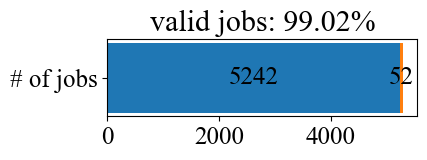

In [6]:

num_jobs = len(df['job_name'].unique())
num_valid_jobs = len(df_valid['job_name'].unique())
print(f"Valid jobs / total jobs: {num_valid_jobs}/{num_jobs} ({num_valid_jobs/num_jobs*100:.2f}%)")

fig, ax = plt.subplots(figsize=(4, 1))
b = ax.barh(["# of jobs"], [num_valid_jobs])
ax.bar_label(b, label_type="center")
b = ax.barh(["# of jobs"], [num_jobs - num_valid_jobs], left=num_valid_jobs)
ax.bar_label(b, label_type="center")
plt.title(f"valid jobs: {num_valid_jobs/num_jobs*100:.2f}%")


In [7]:
import ast
df_valid['RES'] = df_valid['RES'].apply(ast.literal_eval)
df_valid['num_gpus'] = df_valid['RES'].apply(lambda x: int(x['nvidia.com/gpu']) if 'nvidia.com/gpu' in x else None)

/tmp/ipykernel_7772/781628743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['RES'] = df_valid['RES'].apply(ast.literal_eval)
/tmp/ipykernel_7772/781628743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['num_gpus'] = df_valid['RES'].apply(lambda x: int(x['nvidia.com/gpu']) if 'nvidia.com/gpu' in x else None)


Text(0.5, 1.0, 'GPU jobs: 58.13%')

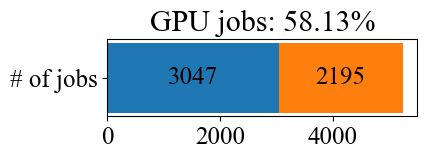

In [8]:
# filter out GPU-only jobs
df_GPU = df_valid[df_valid['num_gpus'].notna()]
num_GPU_jobs = len(df_GPU['job_name'].unique())
_, ax = plt.subplots(figsize=(4, 1))

b = ax.barh(["# of jobs"], [num_GPU_jobs])
ax.bar_label(b, label_type="center")
b = ax.barh(["# of jobs"], [num_valid_jobs - num_GPU_jobs], left=num_GPU_jobs)
ax.bar_label(b, label_type="center")
plt.title(f"GPU jobs: {num_GPU_jobs/num_valid_jobs*100:.2f}%")

In [9]:
df_valid = df_GPU

Text(0.5, 1.0, 'Worker GPU usage')

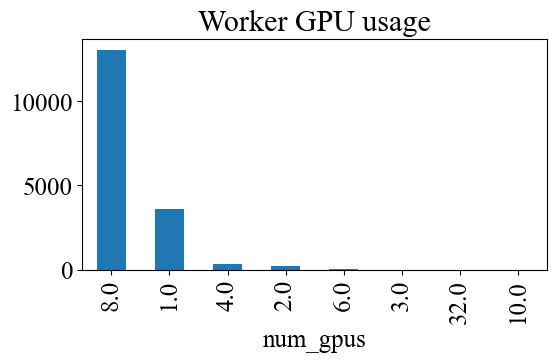

In [10]:
vc = df_valid['num_gpus'].value_counts()
_, ax = plt.subplots(figsize=(6, 3))
vc.plot(kind='bar', ax=ax)
plt.title('Worker GPU usage')


Most workers use all 8 GPUs in a machine.

In [11]:
jobs = df_valid['job_name'].unique()
groups = df_valid.groupby('job_name')
groups

In [12]:

list_start_time = []
list_end_time = []
list_num_gpus = []
for job in jobs:
    start_time = groups.get_group(job)['gmt_created'].min()
    end_time = groups.get_group(job)['gmt_pod_finished'].max()
    num_gpus = groups.get_group(job)['num_gpus'].sum()
    
    list_start_time.append(start_time)
    list_end_time.append(end_time)
    list_num_gpus.append(num_gpus)
    
df_jobs = pd.DataFrame({
    "job_name": jobs,
    "start_time": list_start_time,
    "end_time": list_end_time,
    "num_gpus": list_num_gpus
})

df_jobs['duration'] = df_jobs['end_time'] - df_jobs['start_time']

df_jobs
    

,job_name,start_time,end_time,num_gpus,duration
0,dlcar6cqs8mecvlz,0.032639,0.034028,48.0,0.001389
1,dlc1l3ajnoq4jyuw,0.034722,0.044444,48.0,0.009722
2,dlcqbbpj8g3txdux,0.093056,0.095139,48.0,0.002083
3,dlc1bei96sdtujoa,0.096528,0.098611,48.0,0.002083
4,dlc1v3pfd0c8wgui,0.097222,0.099306,16.0,0.002083
...,...,...,...,...,...
3042,dlcn4ghs4dwo4jy9,15.642361,15.642361,1.0,0.000000
3043,dlcad0kqsonj94k8,15.644444,15.653472,1.0,0.009028
3044,dlcxy69z8xv3kgua,15.654861,20.259028,32.0,4.604167
3045,dlc14pos90tl1xgs,15.943056,15.951389,48.0,0.008333


Text(0.5, 1.0, 'Job GPU usage')

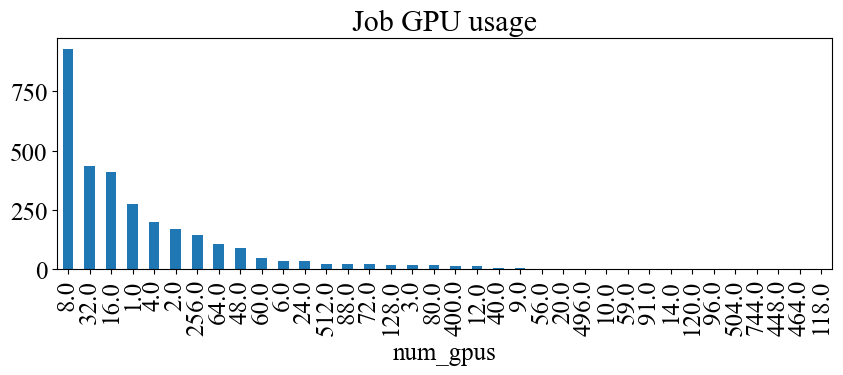

In [13]:
_, ax = plt.subplots(figsize=(10, 3))
vc = df_jobs['num_gpus'].value_counts()
vc.plot(kind='bar', ax=ax)
plt.title("Job GPU usage")

Text(0.5, 1.0, 'Figure 4: Job GPU usage cdf')

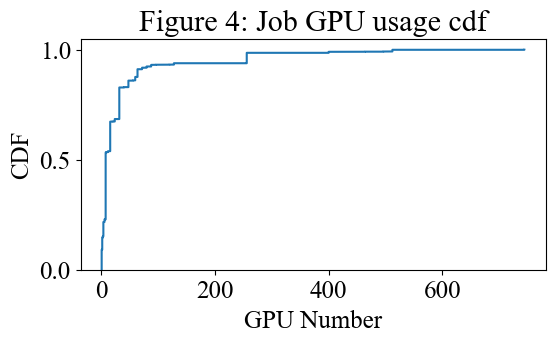

In [14]:
_, ax = plt.subplots(figsize=(6, 3))
ax.ecdf(df_jobs['num_gpus'])
ax.set_ylim(top=1.05)
ax.set_xlabel("GPU Number")
ax.set_ylabel("CDF")
plt.title("Figure 4: Job GPU usage cdf")

Text(0.5, 1.0, 'Figure 5a')

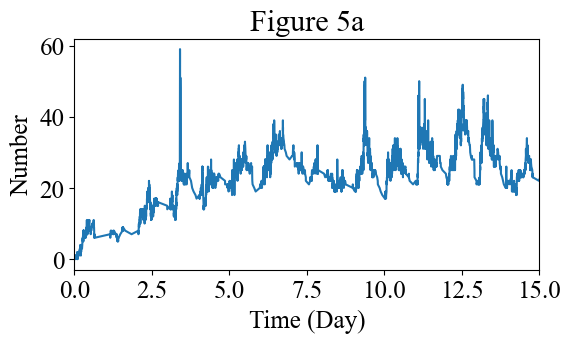

In [15]:
from collections import OrderedDict

def count_jobs_at_each_moment(jobs):
    events = []

    for start, end in jobs:
        events.append((start, 'start'))
        events.append((end, 'end'))

    # Sort events by time, processing end before start at the same time
    events.sort(key=lambda x: (x[0], x[1] == 'start'))

    # Counting jobs over time
    current_active_jobs = 0
    results = {}
    for time, type in events:
        if type == 'start':
            current_active_jobs += 1
        else:
            current_active_jobs -= 1
        results[time] = current_active_jobs
    
    return OrderedDict(sorted(results.items()))

list_tuples = []
for _, row in df_jobs.iterrows():
    list_tuples.append((row['start_time'], row['end_time']))
num_running_jobs_over_time = count_jobs_at_each_moment(list_tuples)
_, ax = plt.subplots(figsize=(6, 3))
times = list(num_running_jobs_over_time.keys())
ax.plot(times, num_running_jobs_over_time.values())
ax.set_xlim((0, 15))
ax.set_xlabel("Time (Day)")
ax.set_ylabel("Number")
plt.title("Figure 5a")

Although the figure is not totally the same as that in the paper, the trend is similar.

Text(0.5, 1.0, 'Figure 5b')

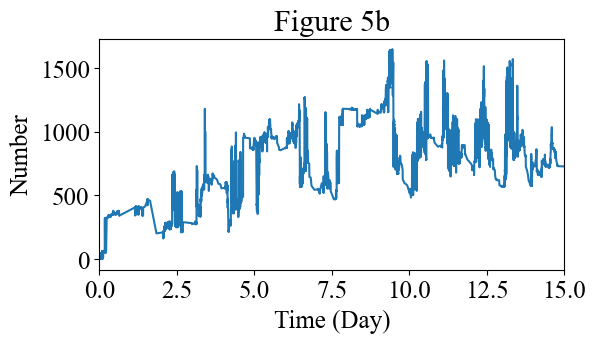

In [16]:
list_tuples = []
for _, row in df_valid.iterrows():
    num_gpus = row['num_gpus']
    for _ in range(int(num_gpus)): 
        list_tuples.append((row['gmt_created'], row['gmt_pod_finished']))
num_running_jobs_over_time = count_jobs_at_each_moment(list_tuples)
_, ax = plt.subplots(figsize=(6, 3))
times = list(num_running_jobs_over_time.keys())
ax.plot(times, num_running_jobs_over_time.values())
ax.set_xlim((0, 15))
ax.set_xlabel("Time (Day)")
ax.set_ylabel("Number")
plt.title("Figure 5b")